## Classificação de radiografias com pneumonia usando Keras

#### Import

In [1]:
# -*- coding: utf-8 -*-

import os
import random

from glob import glob

import cv2
import numpy as np
import pandas as pd

from sklearn.metrics import classification_report, confusion_matrix

from keras import backend as K
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from mlxtend.plotting import plot_confusion_matrix

from imutils import paths
from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

#### Create variables

In [2]:
# Dirs
TRAIN = '../train/'
TEST = '../test/'
VAL = '../val/'

# Dimensions of our images
img_width, img_height = 28, 28

# Settings
classes = ['NORMAL', 'PNEUMONIA']

epochs = 100
batch_size = 32

#### Plot images

In [3]:
# Helpers for plotting images

def plot_image(path, label):
    """Plot an image.
       Using:
        >>> plot_image('train/NORMAL/normal_case.jpeg') 
    """
    img_target = load_img(path)
    img_target.resize((50, 50))
    
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img_target)
    plt.xlabel(label).set_size(50)
    plt.show()

def plot_grid(grid = (1, 2), dataset = []):
    """Plot multiple images.
       Using:
        >>> dataset = [
        .       (get_random_image(TRAIN, 'NORMAL'), 'NORMAL'),
        .       (get_random_image(TRAIN, 'PNEUMONIA'), 'PNEUMONIA')
        .   ]
        >>> plot_grid(grid = (1, 2), dataset = dataset):
    """
    images = [image for (image, label) in dataset]
    labels = [label for (image, label) in dataset]

    fig, axs = plt.subplots(grid[0], grid[1], figsize=(10, 10))
    
    
    for ax, image, label in zip(axs, images, labels):
        image.resize((img_width, img_height))
        ax.imshow(image)
        ax.set_title(label)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        ax.grid(False)

def get_random_image(path, classe):
    """Plot a random image of the target class.
       Using:
        >>> get_random_image('train/NORMAL/normal_case.jpeg', 'NORMAL') 
    """
    imgs = os.listdir(os.path.join(path, classe))
    return load_img(os.path.join(path, classe, random.choice(imgs)))

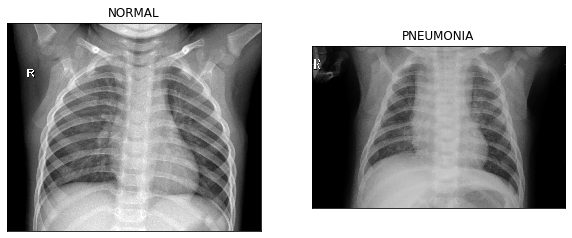

In [4]:
dataset = [
    (get_random_image(TRAIN, classes[0]), classes[0]),
    (get_random_image(TRAIN, classes[1]), classes[1])
]
plot_grid(grid=(1,2), dataset=dataset)

#### Load dataset images

In [5]:
def load_dataset(path):
    data = []
    labels = []

    image_paths = sorted(list(paths.list_images(path)))
    random.seed(42)
    random.shuffle(image_paths)

    for image_path in tqdm(image_paths):
        image = cv2.imread(image_path)
        image = cv2.resize(image, (img_width, img_height))
        image = img_to_array(image)
        data.append(image)

        label = image_path.split(os.path.sep)[-2]
        label = classes.index(label.upper())
        labels.append(label)

    data = np.array(data, dtype="float") / 255.0
    labels = np.array(labels)
    
    return data, labels 

In [6]:
train_data, train_labels = load_dataset(TRAIN)
test_data, test_labels = load_dataset(TEST)
val_data, val_labels = load_dataset(VAL)

100%|██████████| 16/16 [00:00<00:00, 76.50it/s]


In [7]:
train_labels = to_categorical(train_labels, num_classes=2)
test_labels = to_categorical(test_labels, num_classes=2)
val_labels = to_categorical(val_labels, num_classes=2)

In [8]:
aug = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest")

train_batchs = aug.flow(train_data, train_labels, batch_size=batch_size)
test_batchs = aug.flow(test_data, test_labels, batch_size=batch_size)
val_batchs = aug.flow(val_data, val_labels, batch_size=batch_size)

#### Create Sequential model

In [9]:
class LeNet:
    @staticmethod
    def build(width, height, depth, num_classes):
        # initialize the model
        model = Sequential()
        is_channels_first = K.image_data_format() == 'channels_first'
        input_shape = (depth, width, height) if is_channels_first else (width, height, depth)
        
        # first set of CONV => RELU => POOL layers
        model.add(Conv2D(20, (5, 5), padding="same", input_shape=input_shape))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        
        # second set of CONV => RELU => POOL layers
        model.add(Conv2D(50, (5, 5), padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        
        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(500))
        model.add(Activation("relu"))
        
        # softmax classifier
        model.add(Dense(num_classes))
        model.add(Activation("softmax"))
        
        # return the constructed network architecture
        return model

##### Check information about model

In [10]:
model = LeNet.build(width=img_width, height=img_height, depth=3, num_classes=2)

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 20)        1520      
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 20)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 20)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 50)        25050     
_________________________________________________________________
activation_2 (Activation)    (None, 14, 14, 50)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 50)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2450)              0         
__________

##### Compile

In [12]:
model.compile(Adam(lr=0.001, decay=0.001 / epochs), loss='binary_crossentropy', metrics=['accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


#### Performance monitoring

In [13]:
earlyStopping = EarlyStopping(
                monitor='val_loss',
                patience=10,
                verbose=0,
                mode='min')

mcp_save = ModelCheckpoint(
            'models/model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5',
            save_best_only=True,
            monitor='val_loss',
            mode='min')

reduce_lr_loss = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.1,
            patience=7,
            verbose=1,
            epsilon=1e-4,
            mode='min')

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


##### Fit model

In [14]:
model.fit_generator(
    train_batchs,
    steps_per_epoch=len(train_batchs) / batch_size,
    validation_data=(val_data, val_labels),
    validation_steps=len(val_data) / batch_size,
    epochs=epochs,
    callbacks=[earlyStopping, mcp_save, reduce_lr_loss])


Epoch 1/100
6/5 [===================================] - 1s 184ms/step - loss: 0.6588 - acc: 0.6927 - val_loss: 0.7206 - val_acc: 0.5000
Epoch 2/100
6/5 [===================================] - 1s 136ms/step - loss: 0.5474 - acc: 0.7812 - val_loss: 1.1296 - val_acc: 0.5000
Epoch 3/100
6/5 [===================================] - 1s 98ms/step - loss: 0.5508 - acc: 0.7708 - val_loss: 0.7865 - val_acc: 0.5000
Epoch 4/100
6/5 [===================================] - 1s 96ms/step - loss: 0.6211 - acc: 0.6979 - val_loss: 0.7436 - val_acc: 0.5000
Epoch 5/100
6/5 [===================================] - 1s 98ms/step - loss: 0.5150 - acc: 0.8177 - val_loss: 1.0023 - val_acc: 0.5000
Epoch 6/100
6/5 [===================================] - 1s 96ms/step - loss: 0.5603 - acc: 0.7604 - val_loss: 0.8339 - val_acc: 0.5000
Epoch 7/100
6/5 [===================================] - 1s 126ms/step - loss: 0.6220 - acc: 0.6875 - val_loss: 0.7062 - val_acc: 0.5000
Epoch 8/100
6/5 [==================================

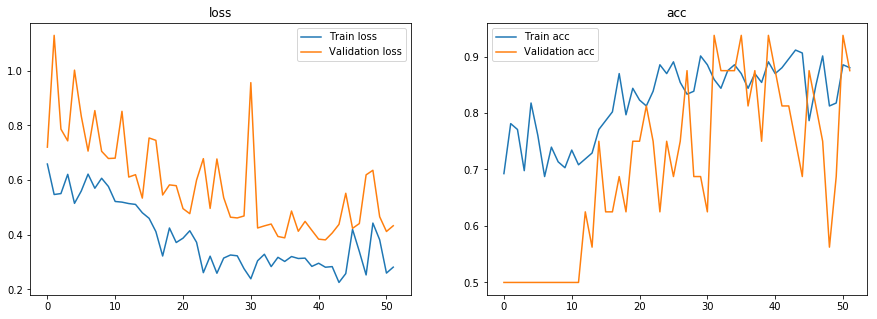

In [15]:
def plot_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

plot_final_history(model.history)

#### Predict

In [16]:
preds = model.predict(test_data)
#preds = model.predict_generator(test_batchs, steps=1, verbose=True)
#preds = np.argmax(preds, axis=-1)

In [17]:
def build_label(probs= []):
    return (1, 0) if probs[0] > probs[1] else (0, 1)

preds = np.asarray(list(map(build_label, preds)))

In [18]:
preds.shape, test_labels.shape

((624, 2), (624, 2))

In [19]:
print("LeNet - batch: {},  epochs: {},  dataset(TEST): {}\n".format(batch_size, epochs, len(test_labels)))
print(classification_report(test_labels[:,0], preds[:,0], target_names=['NORMAL', 'PNEUMONIA']))

LeNet - batch: 32,  epochs: 100,  dataset(TEST): 624

              precision    recall  f1-score   support

      NORMAL       0.83      0.93      0.88       390
   PNEUMONIA       0.85      0.68      0.76       234

   micro avg       0.84      0.84      0.84       624
   macro avg       0.84      0.81      0.82       624
weighted avg       0.84      0.84      0.83       624



<Figure size 432x288 with 0 Axes>

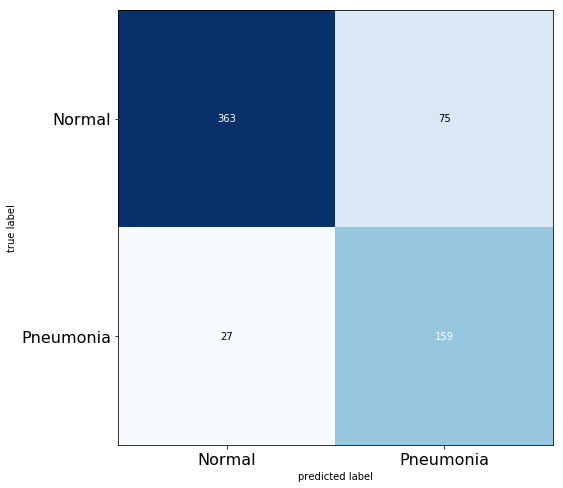

In [20]:
cm  = confusion_matrix(preds[:,0], test_labels[:,0])

plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [21]:
# serialize model to JSON
model_json = model.to_json()
with open("models/lenet_v6.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("models/lenet_v6.h5")
print("Saved model to disk")

Saved model to disk
